## Import Libraries

In [1]:
# import pandas for data wrangling
import pandas as pd
pd.set_option('display.max_columns', None)
# import numpy for vectorize data manipulation
import numpy as np
# import matplotlib.pyplot module for data visualization
import matplotlib.pyplot as plt
# import seaborn for data visualization
import seaborn as sns
# import scipy for certain statistical function
from scipy import stats

# import train and test split method from scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
# import Encoder
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# import SVC model
from sklearn.svm import SVC
# import evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import permutation importance
from sklearn.inspection import permutation_importance


## Load Datasets

In [2]:
df = pd.read_csv("Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Data Understanding

- RowNumber: Index of the row.
- CustomerId: Unique identifier for each customer.
- Surname: Customer's last name (may not be very useful for analysis).
- CreditScore: The credit score of the customer [300 : 850].
  - Poor credit: 300 to 579.
  - Fair credit: 580 to 669.
  - Good credit: 670 to 739.
  - Very good credit: 740 to 799.
  - Excellent credit: 800 to 850.
- Geography: Country of the customer (e.g., France, Spain).
- Gender: Gender of the customer (e.g., Male, Female).
- Age: Age of the customer.
- Tenure: Number of years the customer has been with the bank.
- Balance: Account balance of the customer.
- NumOfProducts: Number of products the customer has purchased.
- HasCrCard: Whether the customer has a credit card (1 = Yes, 0 = No).
- IsActiveMember: Whether the customer is an active member (1 = Yes, 0 = No).
- EstimatedSalary: Estimated annual salary of the customer.
- Exited: Whether the customer left the bank (1 = Yes, 0 = No) — this is likely the target for churn prediction.

### Objectives
**Predict is the customer potentially will churn?**

## Data Wrangling

### Missing Values and Duplicates

In [3]:
# Drop Unsused Column
df.drop(["RowNumber","CustomerId","Surname"], axis=1, inplace=True)

In [4]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


## Data Split

In [7]:
# Feature and Target Split
X = df.drop(["Exited"], axis=1)
y = df["Exited"]

# Train and Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 42)

In [8]:
df = pd.concat([X_train, y_train],axis=1)

## Exploratory Data Analysis
**Analisa beberapa pertanyaan berikut berdasarkan data yang diberikan:**
1. Distribusi Credit Score?
2. Customer Profiling (Age, Geography, Gender)
3. Hubungan Exited dengan Features Categorical
4. Apakah Customer active cenderung tidak churn?
5. APakah Tenure berpengaruh terhadap Churn?

### Churn distribution

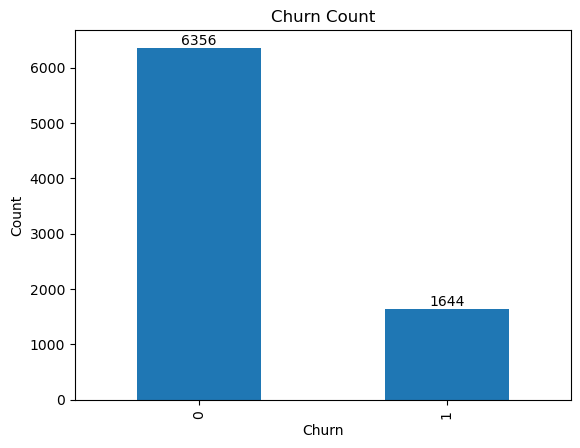

In [9]:
# Target distribution bar chart
ax = df['Exited'].value_counts().plot(kind='bar')

# Set labels and title
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
ax.set_title('Churn Count')

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
plt.show()

In [10]:
df["Exited"].value_counts()/len(df)

Exited
0    0.7945
1    0.2055
Name: count, dtype: float64

We have an Imbalance Data! 79% Existing Customer vs 21% Churn. We'll see if we need to balance this data

### Credit Score Distribution

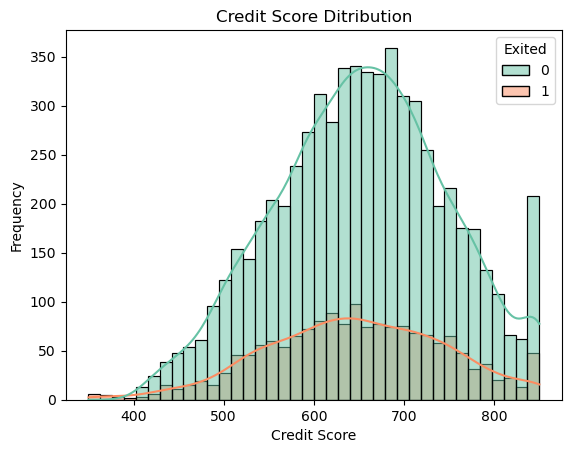

In [11]:
sns.histplot(x='CreditScore', data=df, kde=True, hue="Exited",  palette="Set2")
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.title('Credit Score Ditribution')
plt.show()

It has a little bit Right-skewed Distribution. The distribution is quite same Churn and Existing Customer

### Churn Correlation with other Features

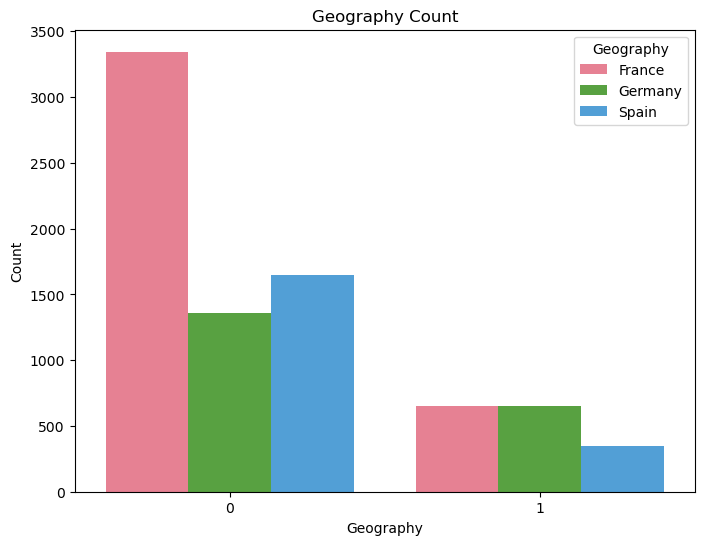

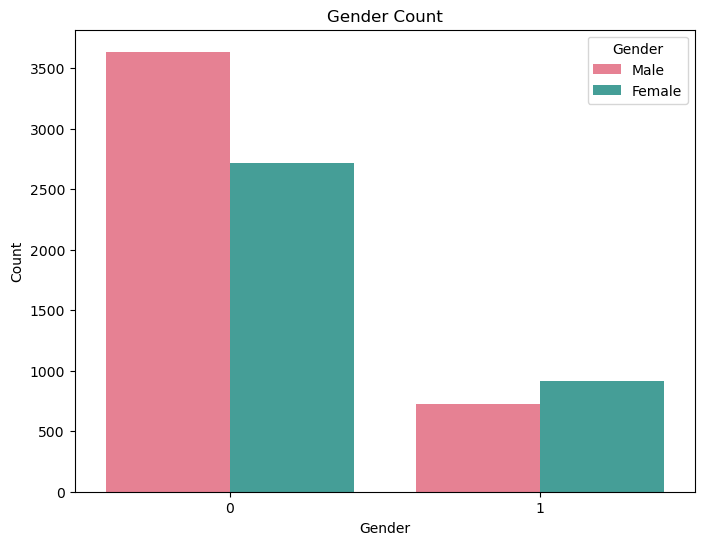

In [12]:
# Categorical Column Distribution
for col in df.select_dtypes(include='object').columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Exited', hue=col, data=df, palette="husl")
    
    # Set labels dan title
    plt.xlabel(col) 
    plt.ylabel('Count')
    plt.title(f'{col} Count')
    
    plt.show()

Insights :
1. France adalah tempat Customer kita paling banyak
2. Customer dari German memiliki kecenderungan Churn yang lebih tinggi, berkebalikan dari France
3. Female lebih cenderung untuk Churn

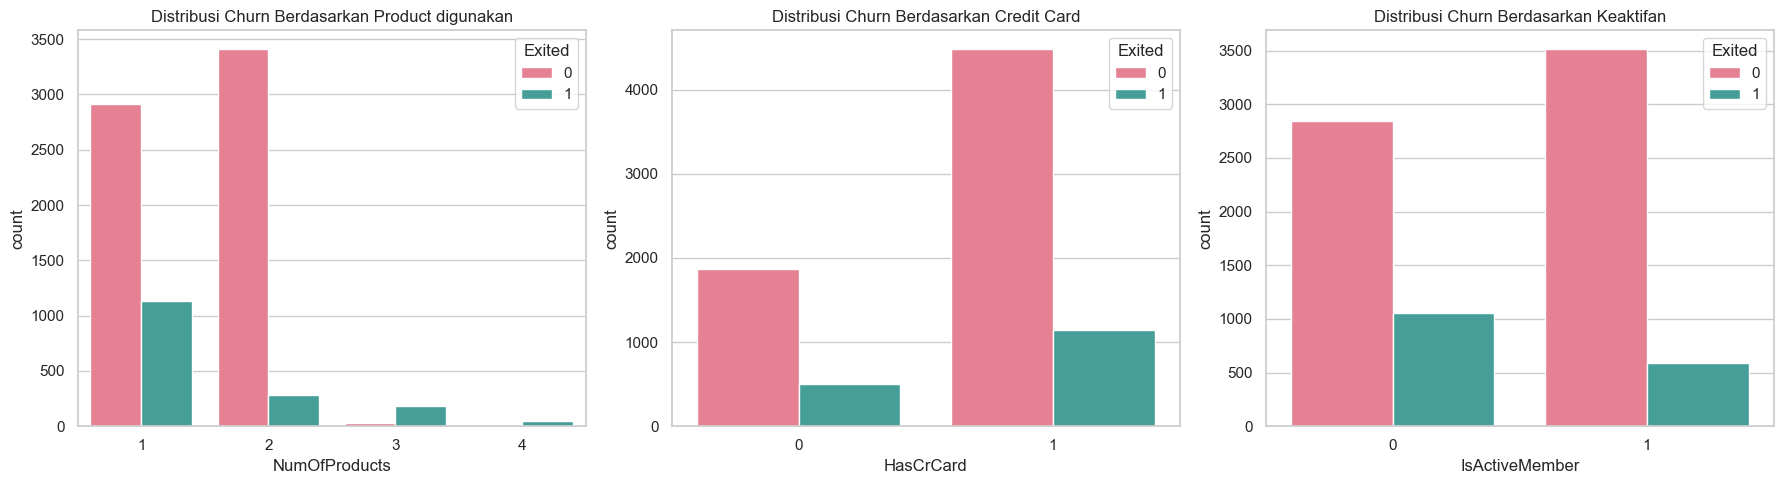

In [13]:
# Setting style untuk seaborn
sns.set(style="whitegrid")

# Plot hubungan antara 'Exited' dan 'Balance'
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.countplot(x='NumOfProducts', hue="Exited", data=df, palette="husl")
plt.title('Distribusi Churn Berdasarkan Product digunakan')

# Plot hubungan antara 'Exited' dan 'Tenure'
plt.subplot(1, 3, 2)
sns.countplot(x='HasCrCard', hue="Exited", data=df,  palette="husl")
plt.title('Distribusi Churn Berdasarkan Credit Card')

# Plot hubungan antara 'Exited' dan 'CreditScore'
plt.subplot(1, 3, 3)
sns.countplot(x='IsActiveMember', hue="Exited", data=df, palette="husl")
plt.title('Distribusi Churn Berdasarkan Keaktifan')

plt.tight_layout()
plt.show()

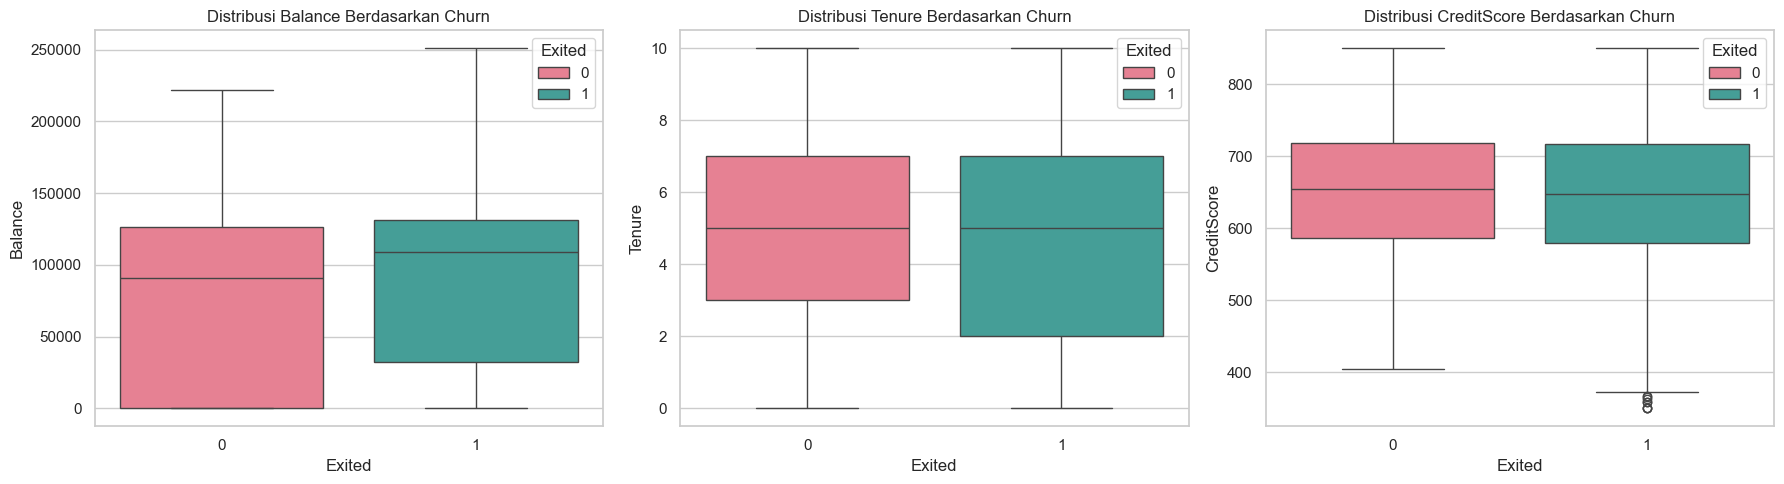

In [14]:

sns.set(style="whitegrid")

# Plot hubungan antara 'Exited' dan 'Balance'
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='Exited', y='Balance', data=df, hue="Exited", palette="husl")
plt.title('Distribusi Balance Berdasarkan Churn')

# Plot hubungan antara 'Exited' dan 'Tenure'
plt.subplot(1, 3, 2)
sns.boxplot(x='Exited', y='Tenure', data=df, hue="Exited", palette="husl")
plt.title('Distribusi Tenure Berdasarkan Churn')

# Plot hubungan antara 'Exited' dan 'CreditScore'
plt.subplot(1, 3, 3)
sns.boxplot(x='Exited', y='CreditScore', data=df, hue="Exited", palette="husl")
plt.title('Distribusi CreditScore Berdasarkan Churn')

plt.tight_layout()
plt.show()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      8000 non-null   int64  
 1   Geography        8000 non-null   object 
 2   Gender           8000 non-null   object 
 3   Age              8000 non-null   int64  
 4   Tenure           8000 non-null   int64  
 5   Balance          8000 non-null   float64
 6   NumOfProducts    8000 non-null   int64  
 7   HasCrCard        8000 non-null   int64  
 8   IsActiveMember   8000 non-null   int64  
 9   EstimatedSalary  8000 non-null   float64
 10  Exited           8000 non-null   int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 750.0+ KB


### Handling Outliers

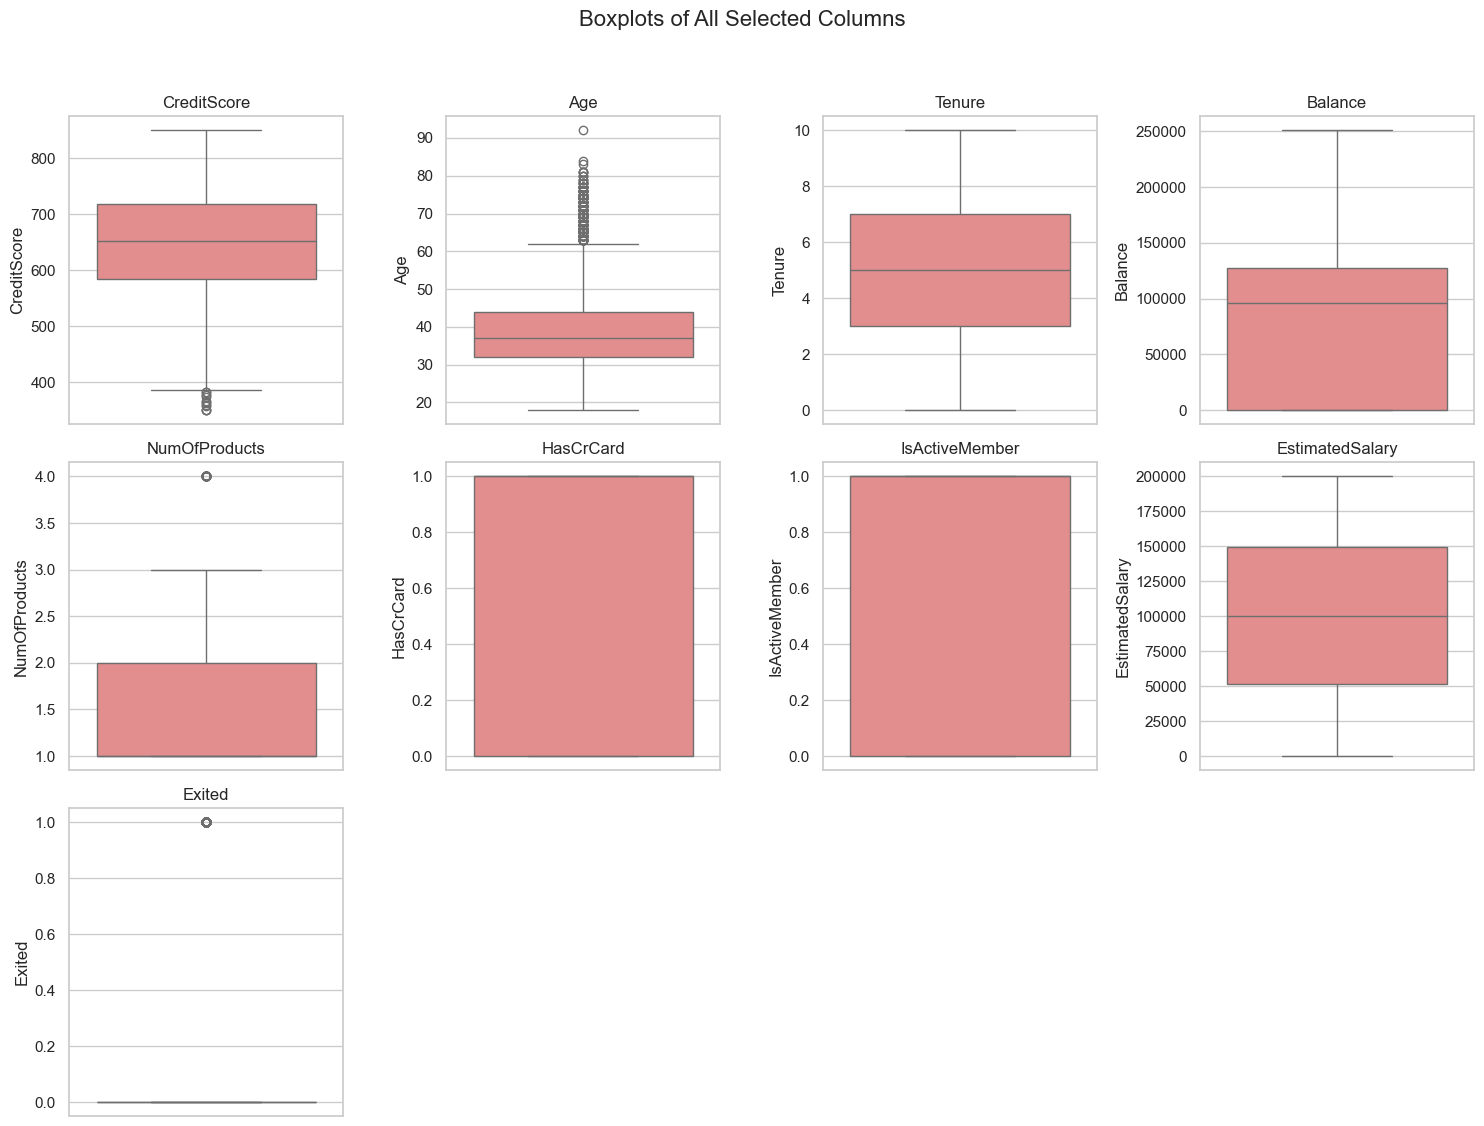

In [16]:
columns = df.select_dtypes(exclude ='object').columns
# Setting up the figure size and grid
plt.figure(figsize=(15, 15))
plt.suptitle("Boxplots of All Selected Columns", fontsize=16)

# Loop through the columns and plot each one as a boxplot
for i, col in enumerate(columns, 1):
    plt.subplot(4, 4, i)  # 4x4 grid, adjust if you need a different layout
    sns.boxplot(y=df[col], color='#F08080')
    plt.title(col)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.show()

Age has so much outliers and it has a negative impact to our models, so we have to handle it.

In [17]:
df["Age"] = np.log1p(df["Age"])

<Axes: ylabel='Age'>

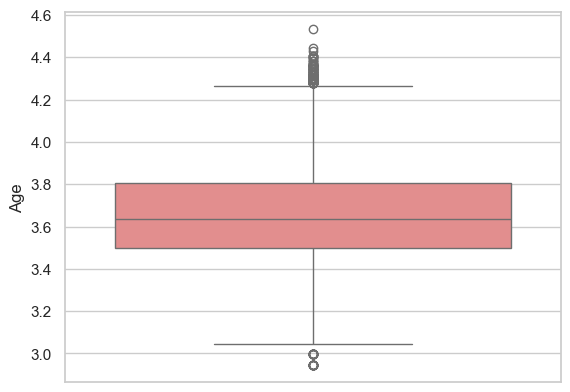

In [18]:
sns.boxplot(y=df["Age"], color='#F08080')

better

## Encoding

In [19]:
# One Hot Encoding 
Geography = pd.get_dummies(df['Geography'],prefix='Geography')

Geography = Geography.astype(int)

In [20]:
df = pd.concat([df, Geography], axis=1)

df.drop(columns="Geography", inplace=True)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
9254,686,Male,3.496508,6,0.00,2,1,1,179093.26,0,1,0,0
1561,632,Male,3.761200,4,119624.60,2,1,1,195978.86,0,0,1,0
1670,559,Male,3.218876,3,114739.92,1,1,0,85891.02,1,0,0,1
6087,561,Female,3.332205,9,135637.00,1,1,0,153080.40,1,1,0,0
6669,517,Male,4.043051,9,142147.32,1,0,0,39488.04,1,1,0,0


In [21]:
# One Hot Encoding 
Geography = pd.get_dummies(X_test['Geography'],prefix='Geography')

Geography = Geography.astype(int)

In [22]:
X_test = pd.concat([X_test, Geography], axis=1)

X_test.drop(columns="Geography", inplace=True)
X_test.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
6252,596,Male,32,3,96709.07,2,0,0,41788.37,0,1,0
4684,623,Male,43,1,0.00,2,1,1,146379.30,1,0,0
1731,601,Female,44,4,0.00,2,1,0,58561.31,0,0,1
4742,506,Male,59,8,119152.10,2,1,1,170679.74,0,1,0
4521,560,Female,27,7,124995.98,1,1,1,114669.79,0,0,1


In [23]:
X_train = df.drop(["Exited"], axis=1)
y_train = df["Exited"]

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        8000 non-null   int64  
 1   Gender             8000 non-null   object 
 2   Age                8000 non-null   float64
 3   Tenure             8000 non-null   int64  
 4   Balance            8000 non-null   float64
 5   NumOfProducts      8000 non-null   int64  
 6   HasCrCard          8000 non-null   int64  
 7   IsActiveMember     8000 non-null   int64  
 8   EstimatedSalary    8000 non-null   float64
 9   Geography_France   8000 non-null   int32  
 10  Geography_Germany  8000 non-null   int32  
 11  Geography_Spain    8000 non-null   int32  
dtypes: float64(3), int32(3), int64(5), object(1)
memory usage: 718.8+ KB


In [25]:
# Label Encoding
le = LabelEncoder()

# Apply label encoding to each categorical column
X_train['Gender'] = le.fit_transform(X_train['Gender'])
X_test['Gender'] = le.fit_transform(X_test['Gender'])

In [26]:
X_train

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
9254,686,1,3.496508,6,0.00,2,1,1,179093.26,1,0,0
1561,632,1,3.761200,4,119624.60,2,1,1,195978.86,0,1,0
1670,559,1,3.218876,3,114739.92,1,1,0,85891.02,0,0,1
6087,561,0,3.332205,9,135637.00,1,1,0,153080.40,1,0,0
6669,517,1,4.043051,9,142147.32,1,0,0,39488.04,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768,1,4.007333,8,69712.74,1,1,1,69381.05,1,0,0
5191,682,0,4.077537,1,0.00,1,1,1,706.50,1,0,0
5390,735,0,3.663562,1,0.00,3,0,0,92220.12,1,0,0
860,667,1,3.784190,8,190227.46,1,1,0,97508.04,1,0,0


## Feature Scaling

In [27]:
feature = list(X_train)

In [28]:
'''from sklearn.preprocessing import StandardScaler

# Inisialisasi scaler
scaler = StandardScaler()

# Fit scaler pada data training dan transformasikan data training
X_train_scaled = scaler.fit_transform(X_train)

# Transformasikan data testing menggunakan scaler yang sudah di-fit
X_test_scaled = scaler.transform(X_test)'''

'from sklearn.preprocessing import StandardScaler\n\n# Inisialisasi scaler\nscaler = StandardScaler()\n\n# Fit scaler pada data training dan transformasikan data training\nX_train_scaled = scaler.fit_transform(X_train)\n\n# Transformasikan data testing menggunakan scaler yang sudah di-fit\nX_test_scaled = scaler.transform(X_test)'

In [29]:
'''X_train = pd.DataFrame(data = X_train_scaled, columns = feature)
X_train.head()'''

'X_train = pd.DataFrame(data = X_train_scaled, columns = feature)\nX_train.head()'

In [30]:
'''X_test = pd.DataFrame(data = X_test_scaled, columns = feature)
X_test.head()'''

'X_test = pd.DataFrame(data = X_test_scaled, columns = feature)\nX_test.head()'

In [31]:
'''from imblearn.over_sampling import SMOTE

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Resampling data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Menampilkan distribusi kelas sebelum dan sesudah
print("Distribusi kelas sebelum SMOTE:", pd.Series(y_train).value_counts())
print("Distribusi kelas setelah SMOTE:", pd.Series(y_resampled).value_counts())'''


'from imblearn.over_sampling import SMOTE\n\n# Inisialisasi SMOTE\nsmote = SMOTE(random_state=42)\n\n# Resampling data\nX_resampled, y_resampled = smote.fit_resample(X_train, y_train)\n\n# Menampilkan distribusi kelas sebelum dan sesudah\nprint("Distribusi kelas sebelum SMOTE:", pd.Series(y_train).value_counts())\nprint("Distribusi kelas setelah SMOTE:", pd.Series(y_resampled).value_counts())'

## Modeling (SVM)

In [32]:
# Create base SVM model
svm = SVC(class_weight='balanced')
svm.fit(X_train, y_train)

SVC(class_weight='balanced')

In [33]:
# Predict on the test set
y_pred = svm.predict(X_test)

# Evaluate base model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.452
              precision    recall  f1-score   support

           0       0.86      0.38      0.53      1607
           1       0.23      0.76      0.35       393

    accuracy                           0.45      2000
   macro avg       0.55      0.57      0.44      2000
weighted avg       0.74      0.45      0.49      2000



This model is quite good to predict Churn. According to Recall 1

Confusion Matrix:
 [[ 607 1000]
 [  96  297]]


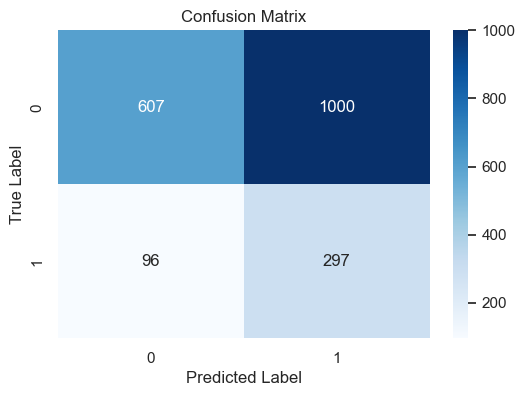

In [34]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Visualisasi confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Permutation Feature Importances for Non-Linear SVM:
               feature  importance
4             Balance    0.050141
0         CreditScore    0.000000
1              Gender    0.000000
2                 Age    0.000000
3              Tenure    0.000000
5       NumOfProducts    0.000000
6           HasCrCard    0.000000
7      IsActiveMember    0.000000
9    Geography_France    0.000000
10  Geography_Germany    0.000000
11    Geography_Spain    0.000000
8     EstimatedSalary   -0.000042


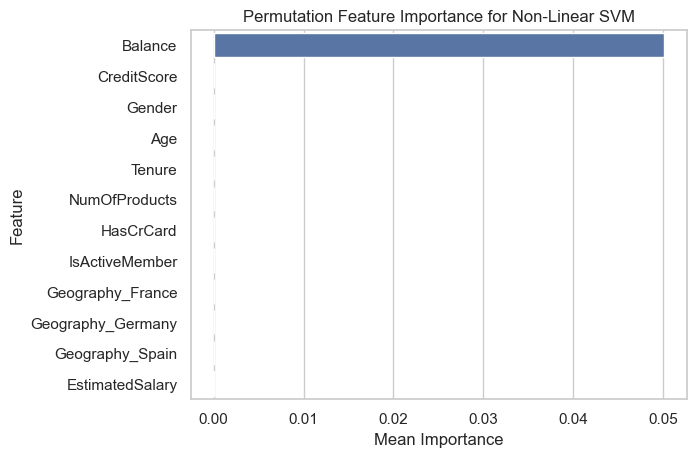

In [36]:
perm_importance = permutation_importance(svm, X_test, y_test, scoring='f1')
   # Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': perm_importance.importances_mean
   }).sort_values(by='importance', ascending=False)
print("Permutation Feature Importances for Non-Linear SVM:\n", feature_importance_df)
# Plot the permutation importance
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title("Permutation Feature Importance for Non-Linear SVM")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.show()

Darisini kita tahu model kita hanya berfokus pada Balance customer untuk menentukan churn atau tidaknya

In [81]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']
}

In [ ]:
# Grid Search with Cross Validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

In [77]:
# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best f1 score: ", grid_search.best_score_)

Best parameters found:  {'C': 0.1, 'kernel': 'rbf'}
Best f1 score:  0.0


In [78]:
# Use the best model for predictions
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test)

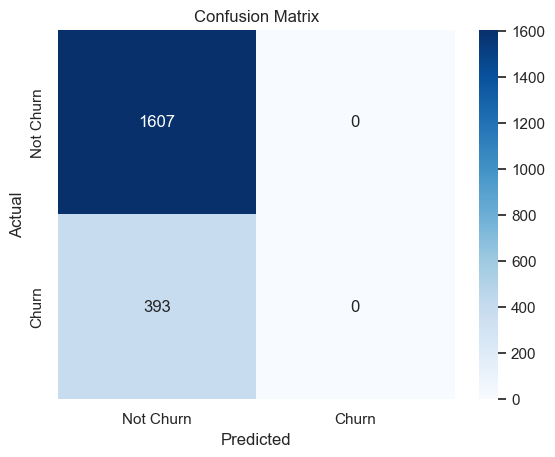

In [79]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred_best)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [80]:
# Check if the best model uses a linear kernel
if grid_search.best_params_['kernel'] == 'linear':
    # Extract feature importance from coefficients
    feature_importance = pd.Series(
        best_svm.coef_.flatten(),
        index=X.columns
    ).abs().sort_values(ascending=False)

    print("Feature Importances for Linear SVM:\n", feature_importance)

    # Plot the feature importance
    feature_importance.plot(kind='bar')
    plt.title("Feature Importance for Linear SVM")
    plt.xlabel("Features")
    plt.ylabel("Importance (absolute value of coefficients)")
    plt.show()

else:
    # Calculate permutation importance for non-linear SVM
    perm_importance = permutation_importance(best_svm, X_test, y_test, scoring='f1')

    # Create DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean
    }).sort_values(by='importance', ascending=False)

    print("Permutation Feature Importances for Non-Linear SVM:\n", feature_importance_df)

    # Plot the permutation importance
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title("Permutation Feature Importance for Non-Linear SVM")
    plt.xlabel("Mean Importance")
    plt.ylabel("Feature")
    plt.show()

ValueError: All arrays must be of the same length